In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

test_all = True
iris_data_location = './Data/iris.data'

In [69]:
class Neuron:
    def __init__(self, id, threshold, leak):
        self.id = id
        self.membrane_voltage = 0
        self.threshold = threshold
        self.leak = leak
        self.incoming_potential = 0
        self.synapses = []

    # accumulate then spike
    def update(self):
        self.membrane_voltage += self.incoming_potential
        
        if self.membrane_voltage < 0:
            self.membrane_voltage = 0
        
        self.incoming_potential = 0

        if self.membrane_voltage > self.threshold:
            self.spike()
            self.membrane_voltage = 0
            
            return 1
        else:
            self.membrane_voltage -= self.leak
            return 0

    def spike(self):
        for s in self.synapses:
            s.send_spike()

    def apply_potential(self, potential):
        self.incoming_potential += potential

    def add_synapse(self, synapse):
        self.synapses.append(synapse)

    def reset(self):
        self.incoming_potential = 0
        self.membrane_voltage = 0

class Synapse:
    def __init__(self, n1, n2, weight):
        self.n1 = n1
        self.n2 = n2
        self.weight = weight

    def send_spike(self):
        self.n2.apply_potential(self.weight)


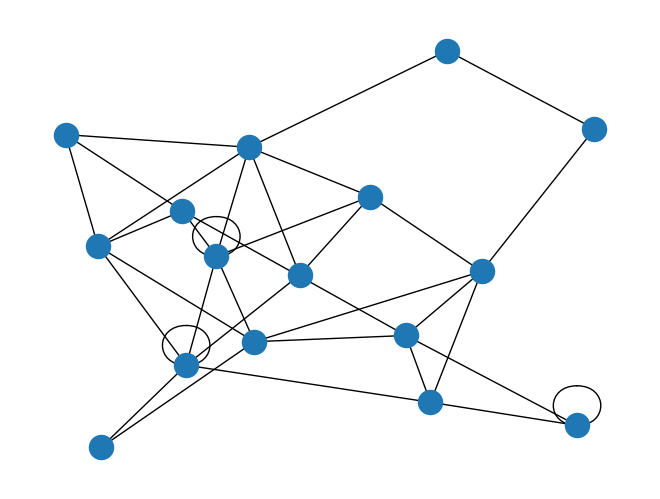

In [95]:
def create_network(n_neurons, n_synapses, negative_weights = False, threshold_range = (0.35, 0.55), leak_range = (0.05, 0.25), weight_factor = 1.8):
    Neurons = []

    for i in range(n_neurons):
        threshold = np.random.uniform(low=threshold_range[0], high=threshold_range[1]) 
        leak = np.random.uniform(low=leak_range[0], high=leak_range[1]) 
        n = Neuron(i, threshold, leak)
        Neurons.append(n)

    for i in range(n_synapses):
        n1_id = np.random.choice(range(n_neurons))
        n2_id = np.random.choice(range(n_neurons))

        n1 = Neurons[n1_id]
        n2 = Neurons[n2_id]

        # positive weights only (should we keep it like that?)
        weight = np.random.rand(1) * weight_factor

        if negative_weights:
            weight -= weight_factor/2

        s = Synapse(n1, n2, weight)

        Neurons[n1_id].add_synapse(s)

    return Neurons

test_network = False

if test_network | test_all:
    # n_neurons = 10
    # n_synapses = 30
    n_neurons = 16
    n_synapses = int(n_neurons * np.random.uniform(low=2, high=3)) # random number from n_neurons * 2 to n_neurons * 3
    

    Neurons = create_network(n_neurons, n_synapses)
    
    # visualize
    G = nx.Graph()

    for n in Neurons:
        G.add_node(n.id)

        for s in n.synapses:
            G.add_edge(n.id, s.n2.id)

    nx.draw(G)
    # plt.savefig('Images/network.pdf')
    plt.show()

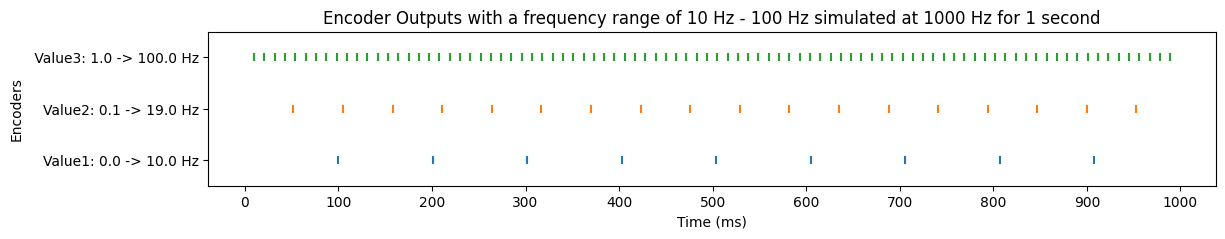

In [96]:
# rate encoder
#   higher values into the network -> more active network (since positive wieght values only)
#   lower values into the network -> less active network
class Encoder:
    def __init__(self, min_f, max_f, sim_f):
        self.last_fire = 0

        # min, max, and simulation frequencies that can be represented
        self.min_f = min_f
        self.max_f = max_f
        self.sim_f = sim_f

        
    def set_value(self, value):
        # using the min and max frequency, calculate the frequency of the value
        self.value = value
        self.value_f = ((self.max_f - self.min_f) * value) + self.min_f

        # using the simulation frequency, calculate the period of the value
        #   (the number of simulation time steps between fires)
        self.fire_period = self.sim_f / self.value_f
        
        # a potentialy faster, but memory hungry way to implement would be a look up table

    def update(self):
        self.last_fire += 1

        # fire everytime the fire period is completed
        if self.last_fire > self.fire_period:
            self.last_fire = 0
            return 1
        else:
            return 0

    def reset(self):
        self.last_fire = 0

test_encoder = True

if test_encoder | test_all:
    min_f = 10
    max_f = 100
    sim_f = 1000

    value1 = 0.0
    value2 = 0.1
    value3 = 1.0

    e1 = Encoder(min_f, max_f, sim_f) 
    e2 = Encoder(min_f, max_f, sim_f)
    e3 = Encoder(min_f, max_f, sim_f)
    
    e1.set_value(value1)
    e2.set_value(value2)
    e3.set_value(value3)

    # simulate for one second
    fires1 = []
    fires2 = []
    fires3 = []
    for t in range(sim_f):
        if e1.update():
            fires1.append(t)

        if e2.update():
            fires2.append(t)

        if e3.update():
            fires3.append(t)

    fig = plt.subplots(figsize=(13,2))
    plt.title(f'Encoder Outputs with a frequency range of {min_f} Hz - {max_f} Hz simulated at {sim_f} Hz for 1 second')
    e_labels=[f'Value1: {value1} -> {e1.value_f} Hz',f'Value2: {value2} -> {e2.value_f} Hz',f' Value3: {value3} -> {e3.value_f} Hz']
    plt.yticks(ticks=[1, 2, 3], labels=e_labels)
    plt.ylabel('Encoders')
    plt.ylim(0.5, 3.5)
    plt.xlabel('Time (ms)')

    plt.xticks(ticks=range(0, sim_f + 1, 100))
    
    plt.scatter(fires1, np.ones(len(fires1)) * 1, marker='|')
    plt.scatter(fires2, np.ones(len(fires2)) * 2, marker='|')
    plt.scatter(fires3, np.ones(len(fires3)) * 3, marker='|')
    # plt.savefig('Images/Example_enc.pdf')
    plt.show()

In [5]:
# read in the Iris data, can be a subset where the data is limited to 2 classes and 2 attributes
def read_iris_data(filepath, subset=False):
    classes = { 'Iris-setosa' : 0,
                'Iris-versicolor' : 1,
                'Iris-virginica' : 2
                }

    attributes = {  0 : 'Sepal Length', 
                    1 : 'Sepal Width',
                    2 : 'Petal Length',
                    3 : 'Petal Width'
                    }

    if subset:
        classes.pop('Iris-virginica')
        attributes.pop(2)
        attributes.pop(3)

    iris_data = []
    labels = []
    with open(filepath, 'r') as f:
        for l in f:
            d = l.strip().split(',')
            

            if d[-1] in classes:
                labels.append(classes[d[-1]])
                iris_data.append(d[0:4])

    iris_data = np.asarray(iris_data, np.float32)
    labels = np.asarray(labels, np.int32)

    return iris_data, labels, classes, attributes

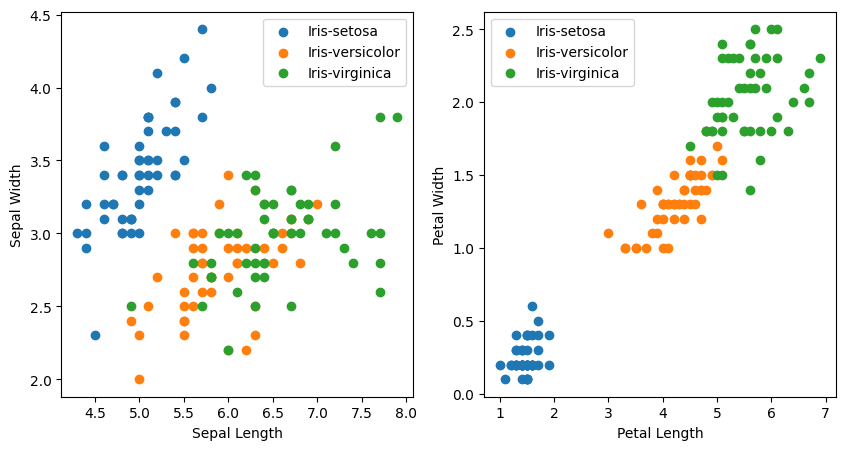

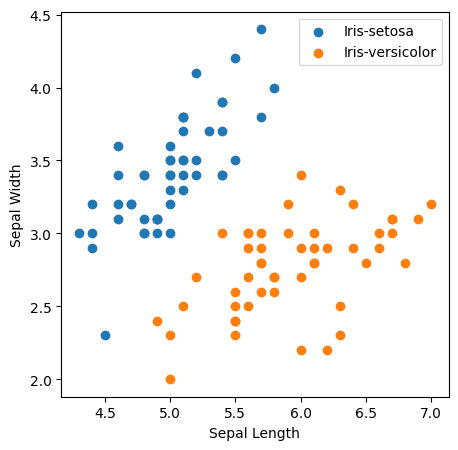

In [84]:
# plot the data
def plot_data(data, classes, attributes):
    n_plots = int(len(attributes) / 2)

    fig, ax = plt.subplots(1, n_plots, figsize=(5*n_plots,5))
    
    for l, i in classes.items():
        for j, ax_i in enumerate(fig.axes):
            ax_i.scatter(data[labels==i, 2*j], data[labels==i, 2*j+1], label = l)

    for i, ax_i in enumerate(fig.axes):
        ax_i.set_xlabel(attributes[2*i])
        ax_i.set_ylabel(attributes[2*i+1])
        ax_i.legend()
    

test_data = False
if test_data | test_all:
    iris_data, labels, classes, attributes = read_iris_data(iris_data_location)
    
    plot_data(iris_data, classes, attributes)

    iris_data, labels, classes, attributes = read_iris_data(iris_data_location, subset=True)
    
    plot_data(iris_data, classes, attributes)

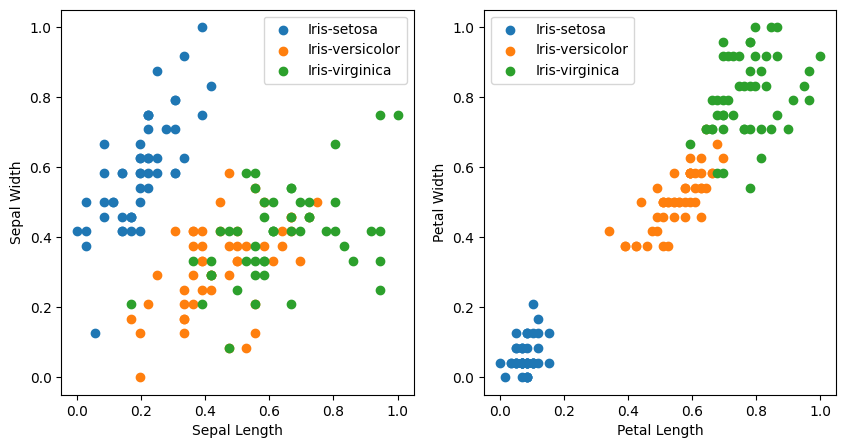

In [97]:
# normalize the data to a range of 0.0 to 1.0 in order to use the Encoders
def normalize_iris_data(iris_data):

    normalized_iris_data = []
    for i, a in attributes.items():
        dmin = np.min(iris_data[:, i])
        
        dmax = np.max(iris_data[:, i])
        
        v = (iris_data[:,i] - dmin) / (dmax - dmin)
        normalized_iris_data.append(list(v))

    normalized_iris_data = np.asarray(normalized_iris_data).reshape(len(attributes), len(iris_data))
    normalized_iris_data = np.transpose(normalized_iris_data)

    return normalized_iris_data

test_normalized = False
if test_normalized | test_all:
    iris_data, labels, classes, attributes = read_iris_data(iris_data_location)

    normalized_iris_data = normalize_iris_data(iris_data)
    
    plot_data(normalized_iris_data, classes, attributes)
    # plt.savefig('Images/Normalized_data.pdf')
    

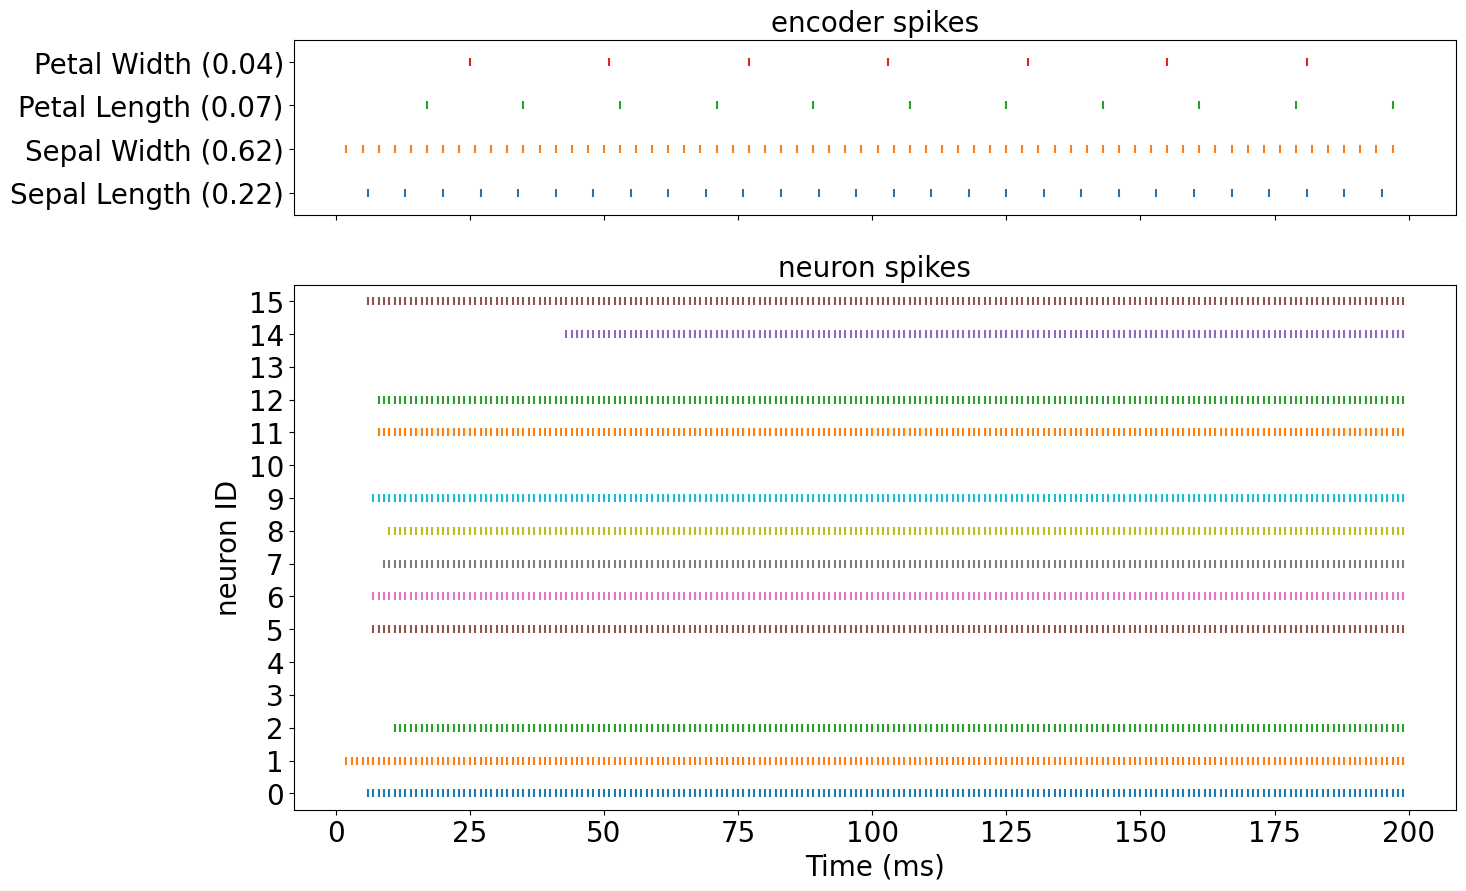

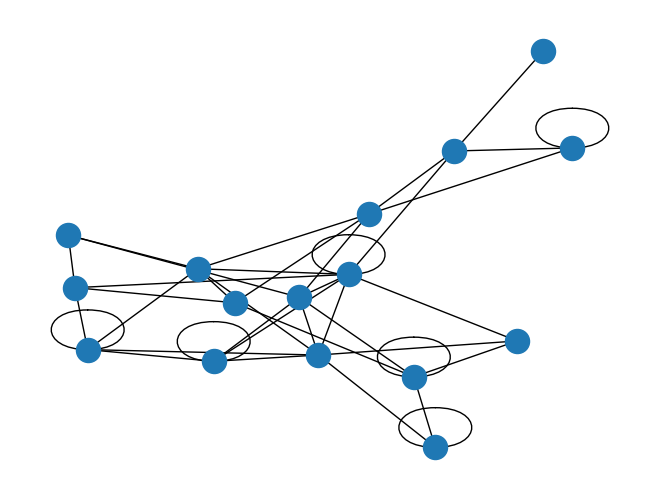

In [110]:
# create a network with encoders and feed it a sample from the dataset
def create_encoders(attributes, min_f = 10, max_f = 700, sim_f = 1000):
    encoders = []
    for i, a in attributes.items():
        e = Encoder(min_f, max_f, sim_f)
        encoders.append(e)

    return encoders

def run_network(neurons, encoders, enc_input, sim_time):
    for i, e in enumerate(encoders):
        e.set_value(enc_input[i])

    # simulate
    fires = []
    for i in range(n_neurons + len(encoders)):
        fires.append([])

    for t in range(sim_time):
        # get the input for this timestep, and apply it to input neurons
        for i, e in enumerate(encoders):
            if e.update():
                fires[i].append(t)
                neurons[i].apply_potential(1)

        # update the network
        for n in neurons:
            if n.update():
                fires[n.id + len(encoders)].append(t)

    return fires

def reset_network(neurons, encoders):
    for n in neurons:
        n.reset()
    
    for e in encoders:
        e.reset()

def plot_spikes(fires, attributes, einputs, sim_time):
    n_neurons = len(fires) - len(attributes)

    fig, ax = plt.subplots(2, 1, figsize=(15,10), sharex=True, gridspec_kw={'height_ratios' : [1, 3]})

    for i, f in enumerate(fires):
        # plot encoders on separate axis
        if i < len(attributes):
            ax[0].scatter(f, np.ones(len(f)) * i, marker='|')
        else:
            ax[1].scatter(f, np.ones(len(f)) * (i - len(attributes)), marker='|')

    enc_labels = []
    for v, ei in zip(attributes.values(), einputs):
        enc_labels.append(f'{v} ({ei:.2f})')

    ax[0].set_ylim(-0.5, len(attributes) - 0.5)
    ax[0].set_yticks(ticks=range(len(attributes)), labels=enc_labels)
    ax[0].tick_params(axis='both', labelsize=20)
    ax[0].set_title('encoder spikes', fontsize=20)

    ax[1].set_ylim(-0.5, n_neurons - 0.5)
    ax[1].set_yticks(ticks=range(n_neurons), labels=range(n_neurons))
    ax[1].tick_params(axis='both', labelsize=20)
    ax[1].set_ylabel('neuron ID', fontsize=20)
    ax[1].set_title('neuron spikes', fontsize=20)


    ax[1].set_xlabel('Time (ms)', fontsize=20)

    # plt.savefig('Images/Network_output_w_enc.pdf')
    plt.show()

test_run = False

if test_run | test_all:

    iris_data, labels, classes, attributes = read_iris_data(iris_data_location)

    normalized_iris_data = normalize_iris_data(iris_data)
    
    # create a test network and encoders
    n_neurons = 16
    n_synapses = int(n_neurons * np.random.uniform(low=2, high=3)) # random number from n_neurons * 2 to n_neurons * 3

    neurons = create_network(n_neurons, n_synapses)

    encoders = create_encoders(attributes)

    sim_time = 200

    # feed a test sample into the test network
    fires = run_network(neurons, encoders, normalized_iris_data[0], sim_time)

    reset_network(neurons, encoders)

    plot_spikes(fires, attributes, normalized_iris_data[0], sim_time)

    # visualize network
    G = nx.Graph()

    for n in neurons:
        G.add_node(n.id)

        for s in n.synapses:
            G.add_edge(n.id, s.n2.id)

    nx.draw(G)

In [ ]:
# time for some training / EO idea
    # Generate a random SNN
    # for each sample in the dataset
        # feed sample into SNN with encoders and simulate for some time (sim_time)
        # find steady state
        # convert spikes of every neuron into an spikes over the seady state time (Fire Matrix)
        # Average Fire Matrix along the time axis (x) and do Mat Mul with DPE weights (y)
        # train DPE layer with Gradient Descent
    # Final accuracy (trainability of SNN) can be used as the fitness of generated SNN
    # number of output neurons required can also be used as the fitness of generated SNN (would require multiple DPEs per SNN to be tested (should be fast))
    # Save SNN with fitness
    # repeat 'till a collecion (population) of SNNs with fitnesses are obtained and do EO

# Future Idea
    # Generate multiple SNNs and have one DPE all of them
    # train the DPE like before, and use the collection of SNNs as a genome for EO

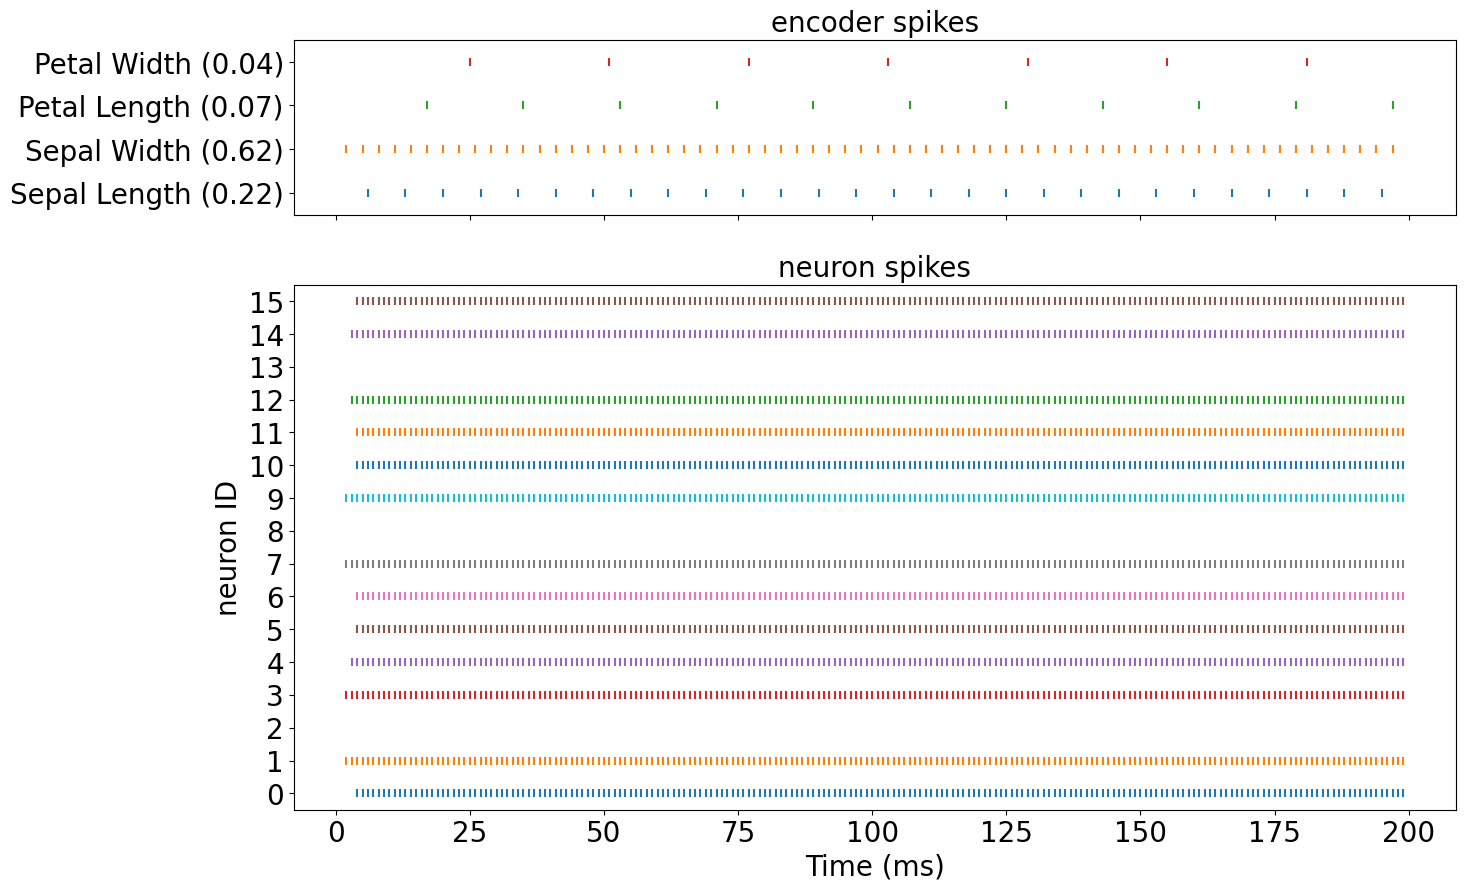

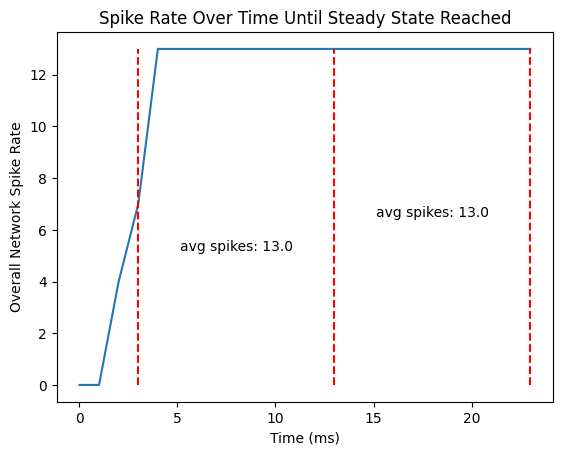

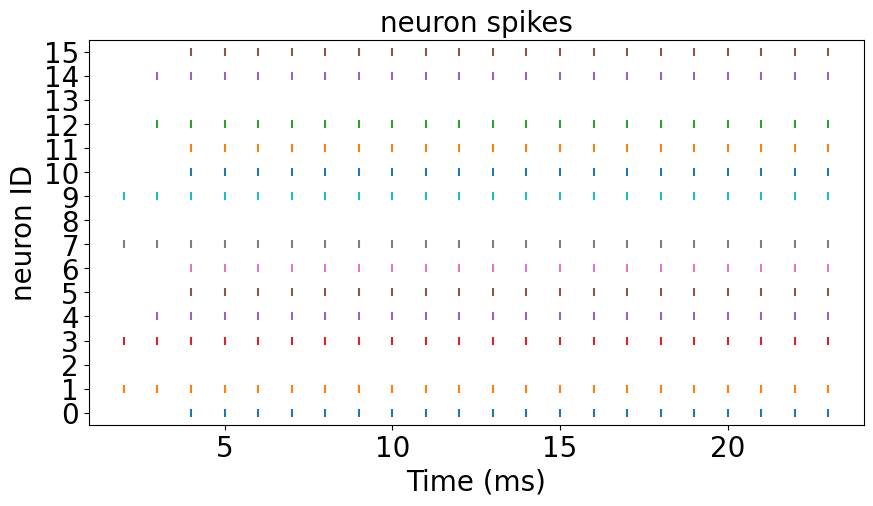

In [139]:
# for each timestep
#   sum the total fires
#   if the average fires over the last window_size timesteps is about equal to the windowsize before that, steady state has been reached
def find_steady_state(sim_time, attributes, fires, window_size=10):
    # will hold the output of each neuron over the steady state (0 -> no fire @ t, 1 -> fire @ t)
    fire_matrix = [] 
    # the sum of all fires over the simulation time
    total_fires = []
    steady_state_t = 0
    m1 = 0
    m2 = 0

    for t in range(sim_time):
        fire_matrix.append([])
        fires_at_t = 0

        # exclude encoder spikes
        for f in fires[len(attributes):]:
            
            if t in f:
                fires_at_t += 1
                fire_matrix[-1].append(1)
            else:
                fire_matrix[-1].append(0)

        if t > window_size*2:
            m1 = np.mean(total_fires[-window_size*2:-window_size])
            m2 = np.mean(total_fires[-window_size:])
            if np.isclose(m1, m2):
                # print(f'steady state at {t}')
                steady_state_t = t
                break

        total_fires.append(fires_at_t)

    return np.asarray(fire_matrix), total_fires, steady_state_t, (m1, m2)

# an updated run_network function with early exit condition determined by steady state logic
def run_network_early_exit(neurons, encoders, enc_input, sim_time, window_size=10):
    # for determing if steady state reached (see next cell)
    total_fires = []
    for i, e in enumerate(encoders):
        e.set_value(enc_input[i])

    # simulate
    fire_matrix = []

    for t in range(sim_time):
        fire_matrix.append([])
        total_fires.append(0)
        # get the input for this timestep, and apply it to input neurons
        for i, e in enumerate(encoders):
            if e.update():
                neurons[i].apply_potential(1)

        # update the network
        for n in neurons:
            if n.update():
                fire_matrix[-1].append(1)
                total_fires[-1] += 1
            else:
                fire_matrix[-1].append(0)

        if t > window_size*2:
            m1 = np.mean(total_fires[-window_size*2:-window_size])
            m2 = np.mean(total_fires[-window_size:])
            if np.isclose(m1, m2):
                # print(f'steady state at {t}')
                steady_state_t = t
                break

    return np.asarray(fire_matrix)

def plot_fire_matrix(fire_matrix):
    n_neurons = len(fire_matrix[0])

    fig, ax = plt.subplots(figsize=(10,5))
    
    for i in range(n_neurons):
        f = fire_matrix[:, i]
        new_f = np.where(np.asarray(f) > 0)[0]
        # print(f)
        # print(new_f)
        # break
        ax.scatter(new_f, np.ones(len(new_f)) * i, marker='|')

    ax.set_ylim(-0.5, n_neurons - 0.5)
    ax.set_yticks(ticks=range(n_neurons), labels=range(n_neurons))
    ax.tick_params(axis='both', labelsize=20)
    ax.set_ylabel('neuron ID', fontsize=20)
    ax.set_title('neuron spikes', fontsize=20)
    ax.set_xlabel('Time (ms)', fontsize=20)

    # plt.savefig('Images/Network_output_w_early_stop.pdf')
    plt.show()


test_steady_state = False

if test_steady_state | test_all:

    iris_data, labels, classes, attributes = read_iris_data(iris_data_location)

    normalized_iris_data = normalize_iris_data(iris_data)

    # create a test network and encoders
    n_neurons = 16
    n_synapses = int(n_neurons * np.random.uniform(low=2, high=3)) # random number from n_neurons * 2 to n_neurons * 3

    neurons = create_network(n_neurons, n_synapses)

    encoders = create_encoders(attributes)

    sim_time = 200
    # feed a test sample into the test network and run it
    fires = run_network(neurons, encoders, normalized_iris_data[0], sim_time)

    reset_network(neurons, encoders)

    plot_spikes(fires, attributes, normalized_iris_data[0], sim_time)

    window_size = 10
    fire_matrix, total_fires, steady_state_t, (m1, m2) = find_steady_state(sim_time, attributes, fires, window_size=window_size)

    if steady_state_t == 0:
        steady_state_t = sim_time
    
    # plotting code
    t = range(steady_state_t)
    plt.plot(t, total_fires)
    plt.xlabel('Time (ms)')
    plt.ylabel('Overall Network Spike Rate')
    plt.title('Spike Rate Over Time Until Steady State Reached')

    # add text and lines
    l_pos = [t[-1], t[-window_size-1], t[-window_size*2-1]] 
    tx1_pos = [l_pos[1] + window_size / 2, max(total_fires) / 2]
    tx2_pos = [l_pos[2] + window_size / 2, max(total_fires) / 2.5]
    plt.vlines(l_pos, 0, max(total_fires), colors='r', linestyles='dashed')
    plt.text(tx1_pos[0], tx1_pos[1], f'avg spikes: {m2}', horizontalalignment='center')
    plt.text(tx2_pos[0], tx2_pos[1], f'avg spikes: {m1}', horizontalalignment='center')
    # plt.savefig('Images/Spike_rate_steady_state.pdf')
    plt.show()

    fire_matrix = run_network_early_exit(neurons, encoders, normalized_iris_data[0], sim_time, window_size=window_size)

    reset_network(neurons, encoders)

    plot_fire_matrix(fire_matrix)


In [140]:
def mse(y, y_hat):
    return np.sum((y - y_hat)**2)

# find the average spiking rate of each neuron (x) and multiply it with the dpe weights
def forward_pass(fire_matrix, dpe_weights):
    n_neurons = len(fire_matrix[0])
    n_classes = dpe_weights.shape[1]

    y = np.zeros(len(classes))

    fire_matrix = np.asarray(fire_matrix)
    x = np.zeros(n_neurons)

    for t in range(len(fire_matrix)):
        x += fire_matrix[t]

    x /= steady_state_t

    y += np.dot(x, dpe_weights)

    return x, y

def update_weights(fire_matrix, dpe_weights, x, y, y_hat, lr=0.005):
    n_neurons = len(fire_matrix[0])
    n_classes = dpe_weights.shape[1]

    e = 2 * (y - y_hat)

    for i in range(n_neurons):
        for j in range(n_classes):
            dpe_weights[i][j] -= e[j] * x[i] * lr

test_weight_update = False

if test_weight_update | test_all:

    iris_data, labels, classes, attributes = read_iris_data(iris_data_location)

    normalized_iris_data = normalize_iris_data(iris_data)

    test_idx = 0

    # create a test network and encoders
    n_neurons = 16
    n_synapses = int(n_neurons * np.random.uniform(low=2, high=3)) # random number from n_neurons * 2 to n_neurons * 3

    neurons = create_network(n_neurons, n_synapses)

    encoders = create_encoders(attributes)

    dpe_weights = np.random.rand(n_neurons, len(classes))

    sim_time = 200

    # show we can reduce error for a singe test sample
    for i in range(10):
        # feed a test sample into the test network
        fire_matrix = run_network_early_exit(neurons, encoders, normalized_iris_data[test_idx], sim_time)

        reset_network(neurons, encoders)

        # fire_matrix, total_fires, steady_state_t, _ = find_steady_state(sim_time, attributes, fires)

        x, y = forward_pass(fire_matrix, dpe_weights)

        y_hat = np.zeros(len(classes))
        y_hat[labels[test_idx]] = 1

        print(f'E{i} = {mse(y, y_hat)}')

        update_weights(fire_matrix, dpe_weights, x, y, y_hat)


E0 = 71.97145378520341
E1 = 59.31110031405217
E2 = 48.877804121650016
E3 = 40.27980804780937
E4 = 33.194268145317764
E5 = 27.355131295447727
E6 = 22.543145247705553
E7 = 18.577625973366086
E8 = 15.309673207265238
E9 = 12.61657942997044


average steady state t = 36.48000000000002


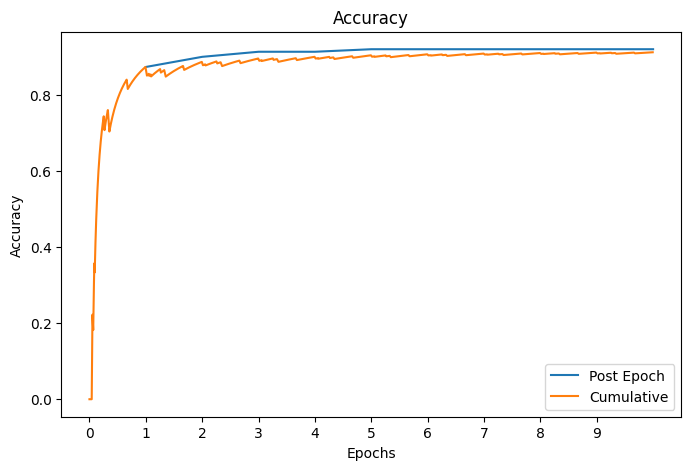

In [169]:
def train_all(data, neurons, encoders, dpe_weights, sim_time = 200, window_size=5, n_epochs=10):
    E_t = []
    cumulative_acc = []
    avg_steady_state_t = 0
    n_proccessed = 0
    
    for epoch in range(n_epochs):
        # for sample in data
        E = 0
        n_correct = 0
        for i, d in enumerate(normalized_iris_data):
            # run network
            fire_matrix = run_network_early_exit(neurons, encoders, d, sim_time)

            reset_network(neurons, encoders)

            # fire_matrix, total_fires, steady_state_t, _ = find_steady_state(sim_time, attributes, fires, window_size=window_size)
            steady_state_t = len(fire_matrix)

            x, y = forward_pass(fire_matrix, dpe_weights)

            y_hat = np.zeros(len(classes))
            y_hat[labels[i]] = 1

            update_weights(fire_matrix, dpe_weights, x, y, y_hat)
            
            correct = 0
            if np.argmax(y) == labels[i]:
                n_correct += 1
                correct = 1

            if n_proccessed == 0:
                avg_steady_state_t = steady_state_t
                cumulative_acc.append(correct)    
            else:
                avg_steady_state_t = (n_proccessed * avg_steady_state_t + steady_state_t)/(n_proccessed+1)
                cumulative_avg = (n_proccessed * cumulative_acc[-1] + float(correct))/(n_proccessed + 1)
                cumulative_acc.append(cumulative_avg)

            n_proccessed += 1
                
        E_t.append(float(n_correct)/len(normalized_iris_data))

            

    return E_t, avg_steady_state_t, cumulative_acc

test_train_all = True

if test_train_all | test_all:
    # read data
    iris_data, labels, classes, attributes = read_iris_data(iris_data_location)

    normalized_iris_data = normalize_iris_data(iris_data)

    #  create network and encoders
    n_neurons = 16
    n_synapses = int(n_neurons * np.random.uniform(low=2, high=3)) # random number from n_neurons * 2 to n_neurons * 3

    # neurons = create_network(n_neurons, n_synapses)

    encoders = create_encoders(attributes)

    # create dpe weights
    dpe_weights = np.random.rand(n_neurons, len(classes))

    E_t = None
    tries = 0
    n_epochs = 10

    while E_t == None and tries < 10:
        neurons = create_network(n_neurons, n_synapses)
        E_t, avg_ss, c_acc = train_all(normalized_iris_data, neurons, encoders, dpe_weights, sim_time=100, window_size=10, n_epochs=n_epochs)
        tries += 1

    print(f'average steady state t = {avg_ss}')
    
    fig = plt.subplots(figsize=(8,5))
    plt.plot(range(len(normalized_iris_data), len(c_acc)+1, int(len(c_acc)/n_epochs)), E_t, label='Post Epoch')
    plt.plot(range(len(c_acc)), c_acc, label='Cumulative')
    plt.xticks(ticks=range(0, 10*len(normalized_iris_data), len(normalized_iris_data)), labels=range(0, 10, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.savefig('Images/Training_accuracy.pdf')
    # print(len(c_acc))
    # print(len(E_t))
    plt.legend()
    plt.show()
    
    # calculate fitness

    # do EO